# Setup Ion Heating Simulation
Setup a group of EBTEL simulations where only the ions are heated and the average interval between events is 750 s. We could, at a later point, extend this to other heating frequencies as well.

In [1]:
import os
import copy
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
import astropy.constants as const

import synthesizAR
from synthesizAR.model_ext import (EbtelInterface, PowerLawScaledWaitingTimes)

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


## Heating Function and Setup

In [2]:
class NanoflareTrain(PowerLawScaledWaitingTimes):
    
    def _calculate_start_times(self,rates):
        scaling_constant = self._calculate_scaling_constant(rates)
        time_start_rise = np.empty([self.number_events])
        wait_time_sum = 0.0
        for i in range(self.number_events):
            wait_time_sum += ((rates[i]**(1.0/self.heating_options['waiting_time_scaling']))
                              / scaling_constant)
            time_start_rise[i] = i*self.heating_options['duration'] + wait_time_sum
        
        return time_start_rise


In [3]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'average_waiting_time':750,
    'waiting_time_scaling':1.0
}

In [4]:
heating_model = NanoflareTrain(heating_options)

## Setup and Run Loop Hydrodynamic Simulation

In [5]:
ih = synthesizAR.util.InputHandler(os.path.join('/home/wtb2/Documents/codes',
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-6
base_config['adaptive_solver_safety'] = 0.5
base_config['total_time'] = 22000.0
base_config['use_flux_limiting'] = True
base_config['heating']['background'] = 1e-6
base_config['heating']['partition'] = 0.0

In [6]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/data/datadrive2/ar_viz/systematic_ar_study/noaa1109_tn750-ion/hydro_config/',
                                 '/data/datadrive2/ar_viz/systematic_ar_study/noaa1109_tn750-ion/hydro_results/'
                                )

In [7]:
field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/base_noaa1109/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-17 13:56:12,975 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-17 13:56:12,975 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-17 13:56:12,977 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-17 13:56:12,978 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-17 13:56:12,978 Parameters: cosmological_simulation   = 0.0


In [8]:
field.configure_loop_simulations(ebtel_interface)

Power-law constrainer reached max # of tries, using best guess with error = 0.0016656726272084033
Power-law constrainer reached max # of tries, using best guess with error = 0.0011518186693686427
Power-law constrainer reached max # of tries, using best guess with error = 0.0010672889027218968
Power-law constrainer reached max # of tries, using best guess with error = 0.0010460066333541906
Power-law constrainer reached max # of tries, using best guess with error = 0.0010978546045472548
Power-law constrainer reached max # of tries, using best guess with error = 0.001014304126455312
Power-law constrainer reached max # of tries, using best guess with error = 0.0014248367594102973
Power-law constrainer reached max # of tries, using best guess with error = 0.0012037621788731911
Power-law constrainer reached max # of tries, using best guess with error = 0.0013439597895161803
Power-law constrainer reached max # of tries, using best guess with error = 0.0011756726556210184
Power-law constrainer

In [9]:
for loop in field.loops:
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [10]:
field.load_loop_simulations(ebtel_interface,
                        savefile='/data/datadrive2/ar_viz/systematic_ar_study/noaa1109_tn750-ion/loop_parameters.h5')

In [11]:
field.save('/data/datadrive2/ar_viz/systematic_ar_study/noaa1109_tn750-ion/field_checkpoint')

(0, 10000000000.0)

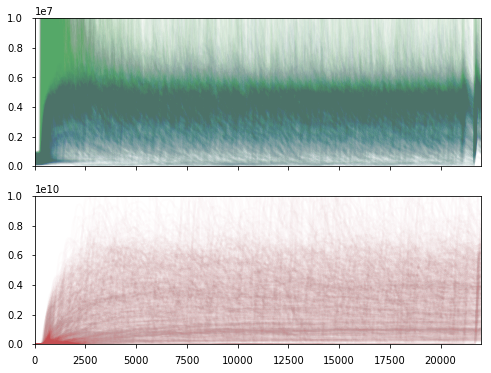

In [12]:
fig,axes = plt.subplots(2,1,figsize=(8,6),sharex=True)
for i,loop in enumerate(field.loops):
    axes[0].plot(loop.time,loop.electron_temperature[:,0],
                 color=sns.color_palette('deep')[0],
                 alpha=.01)
    axes[0].plot(loop.time,loop.ion_temperature[:,0],
                 color=sns.color_palette('deep')[1],
                 alpha=.01)
    axes[1].plot(loop.time,loop.density[:,0],
                 color=sns.color_palette('deep')[2],
                 alpha=.01)
axes[0].set_xlim([0,2.2e4])
axes[0].set_ylim([0,1e7])
axes[1].set_ylim([0,1e10])